In [25]:
import numpy as np
import uproot as up
from matplotlib import pyplot as plt
from scipy.linalg import cholesky, sqrtm
from scipy.stats import norm, rv_histogram
from scipy.optimize import minimize

In [2]:
# Unfolded results from https://t2k-experiment.org/results/2018-transverse-cc0pi/
F = up.open("TKI/dptResults_noreg.root")
unfolded_h = F["Result"].to_numpy()
bins = unfolded_h[1]
unfolded_h = (unfolded_h[0] * 1e38, bins)
F = up.open("TKI/dptResults.root")
pre_regularised_h = F["Result"].to_numpy()
pre_regularised_h = (pre_regularised_h[0] * 1e38, bins)

In [3]:
# Nominal MC from https://ora.ox.ac.uk/objects/uuid:16cef4e8-b52b-48c4-a954-81fba0b7536b Figure 9.4
# Extracted with https://apps.automeris.io/wpd/
nominal = np.loadtxt("TKI/dpt-nominal.txt") / 10.

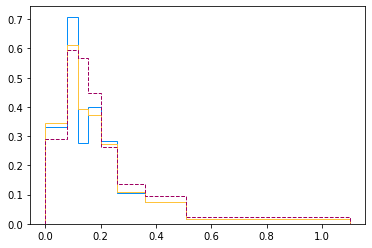

In [4]:
plt.stairs(*unfolded_h)
plt.stairs(*pre_regularised_h)
plt.stairs(nominal, bins, linestyle="dashed")

In [5]:
# Error bars
F = up.open("TKI/dptResults_noreg.root")
cov_unfolded = F["Covariance_Matrix"].to_numpy()[0]
cor_unfolded = cov_unfolded / (
    np.sqrt(np.diag(cov_unfolded))[:, None] * np.sqrt(np.diag(cov_unfolded))[None, :]
)
cov_unfolded_inv = np.linalg.inv(cov_unfolded)
cor_unfolded[~np.isfinite(cor_unfolded)] = 0

F = up.open("TKI/dptResults.root")
cov_pre_regularised = F["Covariance_Matrix"].to_numpy()[0]
cor_pre_regularised = cov_pre_regularised / (
    np.sqrt(np.diag(cov_pre_regularised))[:, None]
    * np.sqrt(np.diag(cov_pre_regularised))[None, :]
)
cov_pre_regularised_inv = np.linalg.inv(cov_pre_regularised)
cor_pre_regularised[~np.isfinite(cor_pre_regularised)] = 0

(
    np.sqrt(np.max(np.diag(cov_unfolded))),
    np.max(cor_unfolded),
    np.min(cor_unfolded),
    np.min(cov_unfolded),
    np.sqrt(np.max(np.diag(cov_pre_regularised))),
    np.max(cor_pre_regularised),
    np.min(cor_pre_regularised),
    np.min(cov_pre_regularised),
)

(0.23052923052360283,
 1.0000000000000002,
 -0.7315042009752449,
 -0.03328873921760593,
 0.12609433271088152,
 1.0000000000000002,
 -0.3601130822204673,
 -0.005602009313643436)

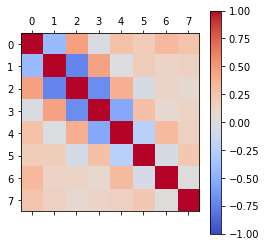

In [6]:
plt.matshow(cor_unfolded, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

In [7]:
# Regularisation
#
# \Delta \chi^2 = x^T C x
#
N = cov_unfolded.shape[0]

# Penalise bin diffrences
# chi = sum_i( (x_i - x_{i+1})^2 )
C_1 = np.diag([1] + [2] * (N - 2) + [1], k=0) + np.diag([-2] * (N - 1), k=1)

# Penalise bin difference differences
# chi = sum_i( (x_i - 2*x_{i+1} + x_{1+2})^2 )
C_2 = (
    np.diag([1] + [5] + [6] * (N - 4) + [5] + [1], k=0)
    + np.diag([-4] + [-8] * (N - 3) + [-4], k=1)
    + np.diag([2] * (N - 2), k=2)
)

# Penalise scaling differences
# x -> x/m
# e.g.
# sum_i( (x_i/m_i - x_{i+1}/m_{i+1})^2 )
model = nominal
model = model / np.mean(model)
C_1s = np.zeros((N, N))
for i in range(N - 1):
    C_1s[i, i] += 1 / model[i] ** 2
    C_1s[i, i + 1] += -2 / (model[i] * model[i + 1])
    C_1s[i + 1, i + 1] += 1 / model[i + 1] ** 2
C_2s = np.zeros((N, N))
for i in range(N - 2):
    C_2s[i, i] += 1 / model[i] ** 2
    C_2s[i, i + 1] += -4 / (model[i] * model[i + 1])
    C_2s[i, i + 2] += 2 / (model[i] * model[i + 2])
    C_2s[i + 1, i + 1] += 4 / model[i + 1] ** 2
    C_2s[i + 1, i + 2] += -4 / (model[i + 1] * model[i + 2])
    C_2s[i + 2, i + 2] += 1 / (model[i + 2] * model[i + 2])

C = C_1s
# Make symmetric
C = (C + C.T) / 2

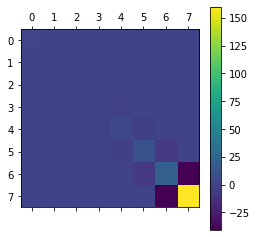

In [8]:
plt.matshow(C)
plt.colorbar()

In [9]:
# Regularised result
#
# m' = A m
# A = (cov^{-1} + C)^-1 cov^{-1}

tau_list = [0.0] + list(np.logspace(0, 2, 9 + 8))
A_list = [
    np.linalg.inv(cov_unfolded_inv + tau * C) @ cov_unfolded_inv for tau in tau_list
]
regularised_list = [A @ unfolded_h[0] for A in A_list]

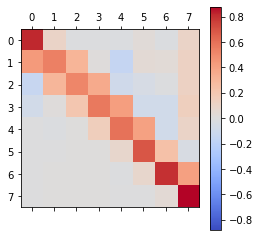

In [10]:
plt.matshow(A_list[-1], cmap="coolwarm", vmin=-np.max(A_list[-1]))
plt.colorbar()

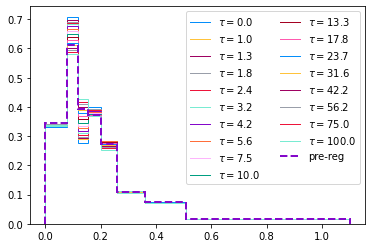

In [11]:
for x, tau in zip(regularised_list, tau_list):
    plt.stairs(x, bins, label=fr"$\tau = {tau:3.1f}$")
plt.stairs(*pre_regularised_h, label="pre-reg", linewidth=2, linestyle="dashed")
plt.legend(ncol=2)

In [12]:
# Metrics
jaggedness = [x.T @ C @ x for x in regularised_list]
bias = [
    (x - unfolded_h[0]).T @ cov_unfolded_inv @ (x - unfolded_h[0])
    for x in regularised_list
]

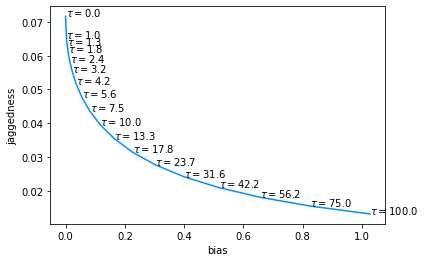

In [13]:
plt.plot(bias, jaggedness)
plt.xlabel("bias")
plt.ylabel("jaggedness")
for x, y, tau in zip(bias, jaggedness, tau_list):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))

In [14]:
# Alt metrics
# Determinant of covariance/correlation matrix as measure of overall correlation?
cov_list = [A @ cov_unfolded @ A.T for A in A_list]
cor_list = [
    np.diag(np.diag(cov) ** (-0.5)) @ cov @ np.diag(np.diag(cov) ** (-0.5))
    for cov in cov_list
]
cov_det_list = [np.linalg.det(cov) for cov in cov_list]
cor_det_list = [np.linalg.det(cor) for cor in cor_list]

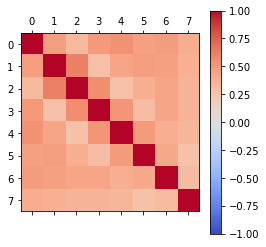

In [15]:
plt.matshow(cor_list[-1], cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()

In [16]:
# Alt metrics
# Wasserstein distance in uncorrelated standard normal space
# The Fréchet distance between multivariate normal distributions
# https://doi.org/10.1016/0047-259X(82)90077-X
dist = []
diag_dist = []


def wasserstein(x, cov, base_x=unfolded_h[0], base_cov=cov_unfolded):
    U = cholesky(np.linalg.inv(base_cov))
    m = U @ base_x
    diff = m - U @ x
    S = U @ cov @ U.T
    d = diff.T @ diff + cov.shape[0] + np.trace(S - 2 * sqrtm(S))
    return abs(d)  # Catch some numerical issues


for x, cov in zip(regularised_list, cov_list):
    # Distance between original and regularised
    dist.append(wasserstein(x, cov))
    # Distance between original and plot
    diag_dist.append(wasserstein(x, np.diag(np.diag(cov))))

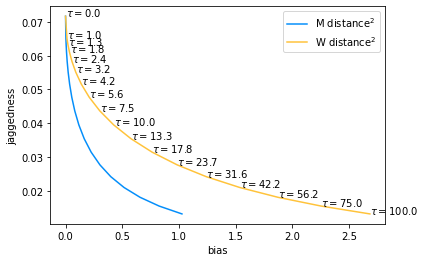

In [17]:
plt.plot(bias, jaggedness, label="M distance$^2$")
plt.plot(dist, jaggedness, label="W distance$^2$")
plt.legend()
plt.xlabel("bias")
plt.ylabel("jaggedness")
for x, y, tau in zip(dist, jaggedness, tau_list):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))

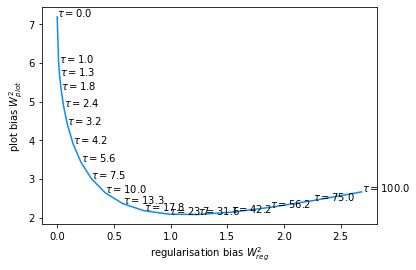

In [18]:
plt.plot(dist, diag_dist)
plt.xlabel("regularisation bias $W^2_{reg}$")
plt.ylabel("plot bias $W^2_{plot}$")
i_W = 0
best = np.inf
for i, (x, y, tau) in enumerate(zip(dist, diag_dist, tau_list)):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))
    if y < best:
        best = y
        i_W = i

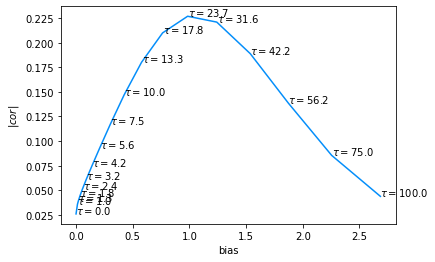

In [19]:
plt.plot(dist, cor_det_list)
plt.xlabel("bias")
plt.ylabel(r"$|cor|$")
i_D = 0
best = 0
for i, (x, y, tau) in enumerate(zip(dist, cor_det_list, tau_list)):
    plt.annotate(fr"$\tau = {tau:.1f}$", (x, y))
    if y > best:
        best = y
        i_D = i

In [20]:
# Closest to published
i_C = 0
best = np.inf
for i, (x, cov) in enumerate(zip(regularised_list, cov_list)):
    d = wasserstein(x, cov, base_x=pre_regularised_h[0], base_cov=cov_pre_regularised)
    if d < best:
        best = d
        i_C = i
print(i_C, tau_list[i_C], best, np.sqrt(best))

11 17.78279410038923 0.13675121237851684 0.36979888098602576


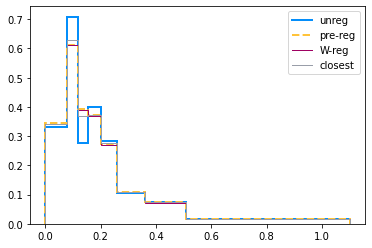

In [21]:
plt.stairs(*unfolded_h, label="unreg", linewidth=2)
plt.stairs(*pre_regularised_h, label="pre-reg", linewidth=2, linestyle="dashed")
plt.stairs(regularised_list[i_W], bins, label="W-reg")
plt.stairs(regularised_list[i_C], bins, label="closest")
plt.legend()

In [32]:
# Minimal possible plot bias
def fun(x):
    return wasserstein(unfolded_h[0], np.diag(x))

ret = minimize(fun, x0=np.diag(cov_unfolded))
best_error = np.sqrt(ret.x)

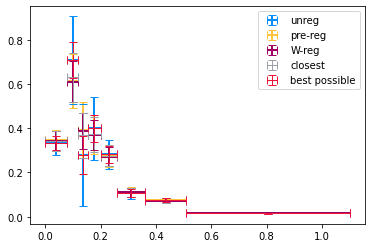

In [33]:
x = (bins[:-1] + bins[1:]) / 2
xerr = (bins[1:] - bins[:-1]) / 2

y = unfolded_h[0]
yerr = np.sqrt(np.diag(cov_unfolded))
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="unreg", linewidth=2, linestyle="", capsize=4
)

y = pre_regularised_h[0]
yerr = np.sqrt(np.diag(cov_pre_regularised))
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="pre-reg", linewidth=2, linestyle="", capsize=4
)

y = regularised_list[i_W]
yerr = np.sqrt(np.diag(cov_list[i_W]))
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="W-reg", linewidth=2, linestyle="", capsize=4
)

y = regularised_list[i_C]
yerr = np.sqrt(np.diag(cov_list[i_C]))
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="closest", linewidth=1, linestyle="", capsize=4
)


y = unfolded_h[0]
yerr = best_error
plt.errorbar(
    x, y, yerr=yerr, xerr=xerr, label="best possible", linewidth=1, linestyle="", capsize=4
)
plt.legend()